In [94]:
# 使用統計學中的ARIMA, ETS 預測隔日收盤價，目前結果只能抓到稍微的趨勢(可能我太弱了不太會設參數QQ)
import pandas as pd
import os
import numpy as np
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt
import datetime

import statsmodels.tsa.holtwinters as ses
import statsmodels.tsa.arima_model as arima_model
import statsmodels.tsa.stattools as tsa_tool

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
myfont=FontProperties(fname=r'biokai.ttf',size=14)
plt.rcParams["figure.figsize"] = (15,10)

In [2]:
# thousand = thousand separator 
df = pd.read_csv("data/company/2317.csv", encoding="big5", thousands=',')
df["日期"] = pd.to_datetime(df["日期"], format="%Y%m%d")
df = df.set_index("日期")

In [3]:
df.head()

,證券代號,證券名稱,產業別,成交股數,成交筆數,成交金額,開盤價,最高價,最低價,收盤價,...,投信賣出股數,投信買賣超股數,自營商買賣超股數,自營商買進股數(自行買賣),自營商賣出股數(自行買賣),自營商買賣超股數(自行買賣),自營商買進股數(避險),自營商賣出股數(避險),自營商買賣超股數(避險),三大法人買賣超股數
日期,,,,,,,,,,,,,,,,,,,,,
2019-01-02,2317,鴻海,其他電子業,16775306,7968,1182131473,71.4,71.4,69.9,70.1,...,0,26000,-1394000,38000,1132000,-1094000,117000,417000,-300000,-6104550
2019-01-03,2317,鴻海,其他電子業,36659461,17345,2526323765,69.0,69.4,68.5,68.9,...,600000,-600000,181000,12000,28000,-16000,532000,335000,197000,-10416196
2019-01-04,2317,鴻海,其他電子業,37313571,18110,2520135828,68.2,68.2,67.0,67.6,...,1606805,-1573805,438000,51000,0,51000,839000,452000,387000,-7633271
2019-01-07,2317,鴻海,其他電子業,24084557,11167,1661796863,68.7,69.4,68.3,69.3,...,355000,-355000,1344000,311000,140000,171000,1369000,196000,1173000,4579348
2019-01-08,2317,鴻海,其他電子業,18303188,8027,1258685500,69.6,69.6,68.2,68.6,...,0,0,-224000,0,122000,-122000,208000,310000,-102000,904293


In [4]:
# data clean
df = df.drop(["證券代號", "證券名稱", "產業別"], axis=1)
df["漲跌(+/-)"] = df["漲跌(+/-)"].map({'+':1, '-':-1, 'X':0}).fillna(method="ffill")
df = df.applymap(lambda x: None if x == "--" else x).fillna(method="ffill")


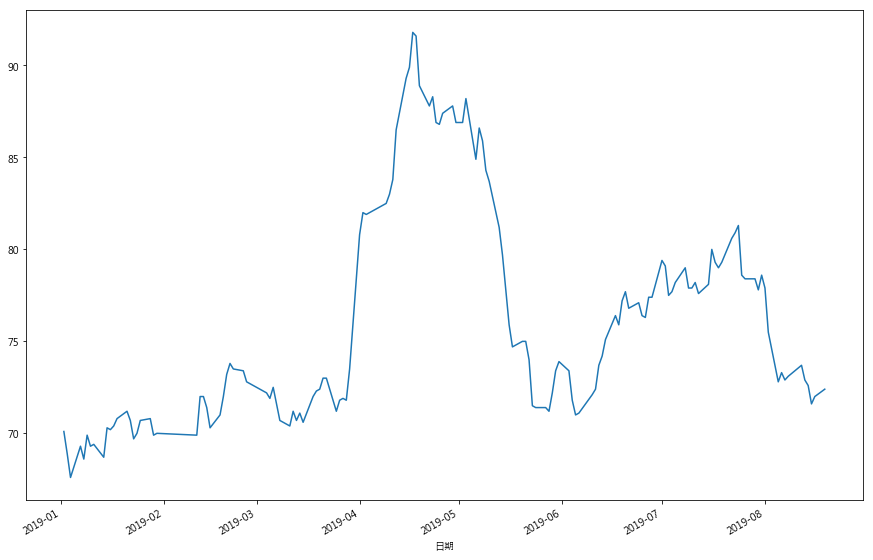

In [13]:
df["收盤價"].plot()

<BarContainer object of 31 artists>

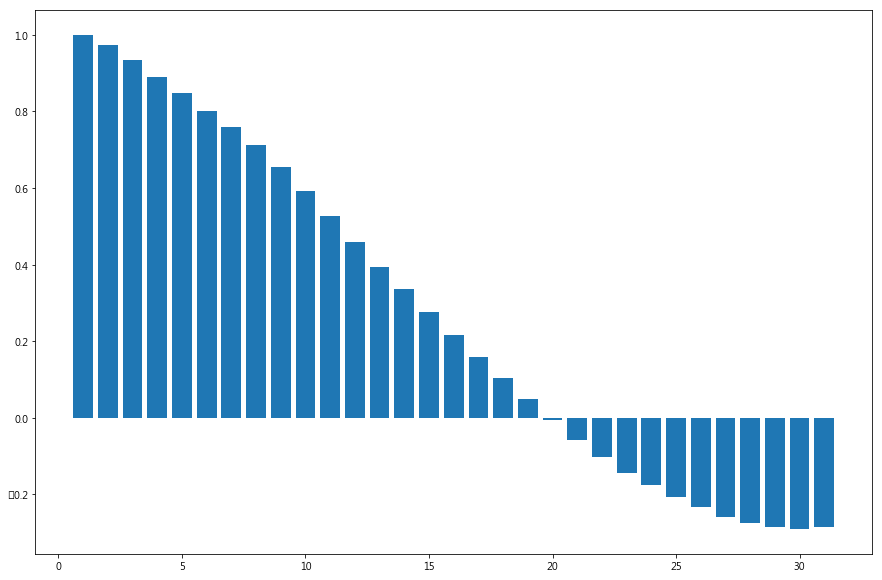

In [16]:
# acf 現在看起來是前幾天正相關滿猛的
acf = tsa_tool.acf(df["收盤價"], nlags=30)
x = [i for i in range(1, len(acf)+1)]
plt.bar(x, acf)


<BarContainer object of 31 artists>

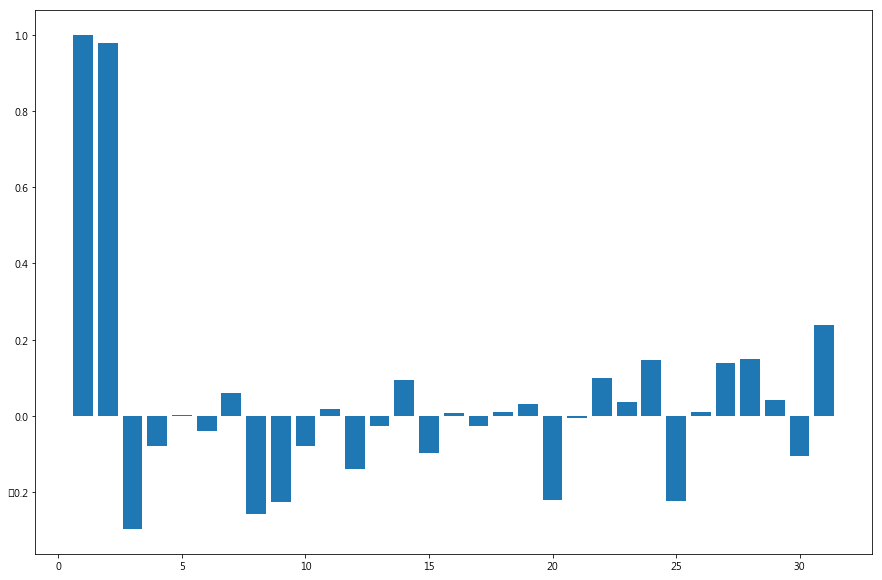

In [17]:
# pacf 看起來應該是 AR(1) model
pacf = tsa_tool.pacf(df["收盤價"], nlags=30)
x = [i for i in range(1, len(acf)+1)]
plt.bar(x, pacf)


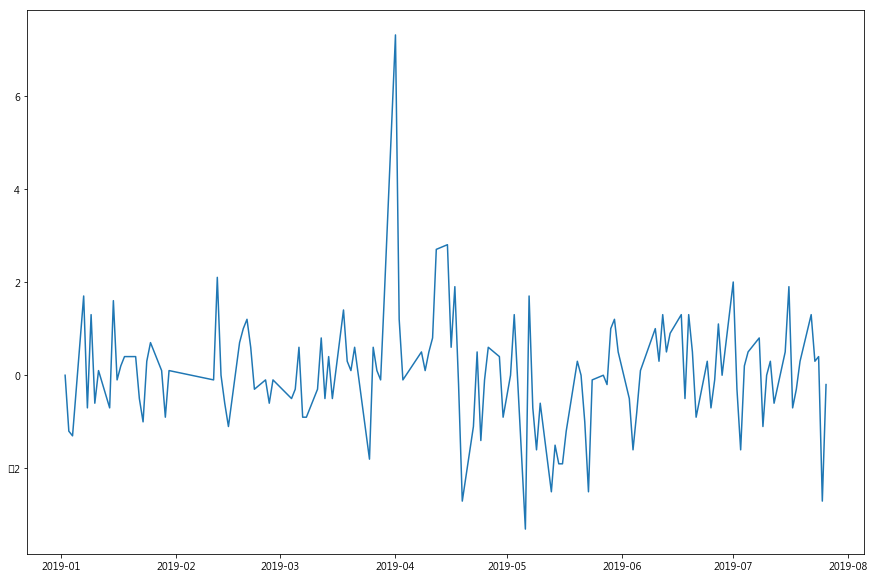

In [19]:
# d=1 to stationoal
d = df["收盤價"] - df["收盤價"].shift().fillna(0)
d.iloc[0] = 0
train, test = train_test_split(d, test_size = 0.1, shuffle=False) 
plt.plot(train)

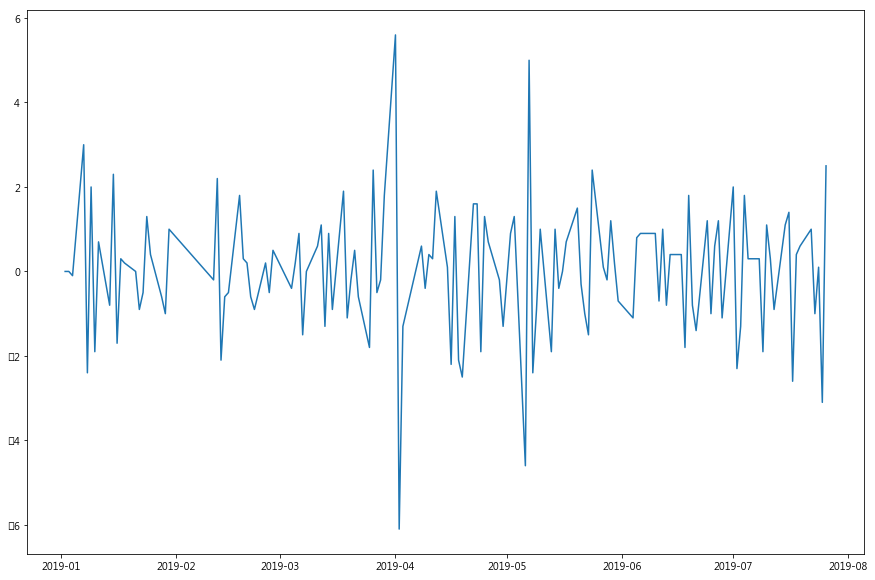

In [29]:
# d=2 to stationoal
d = df["收盤價"] - 2*df["收盤價"].shift(1).fillna(0) + df["收盤價"].shift(2).fillna(0)
d.iloc[0], d.iloc[1] = 0, 0
train, test = train_test_split(d, test_size = 0.1, shuffle=False) 
# d.head()
plt.plot(train)

In [98]:
tsa_tool.adfuller(train)

(-7.956387106522283,
 3.029386893748919e-12,
 6,
 128,
 {'1%': -3.4825006939887997,
  '10%': -2.578960197753906,
  '5%': -2.884397984161377},
 409.6221472820285)

<BarContainer object of 31 artists>

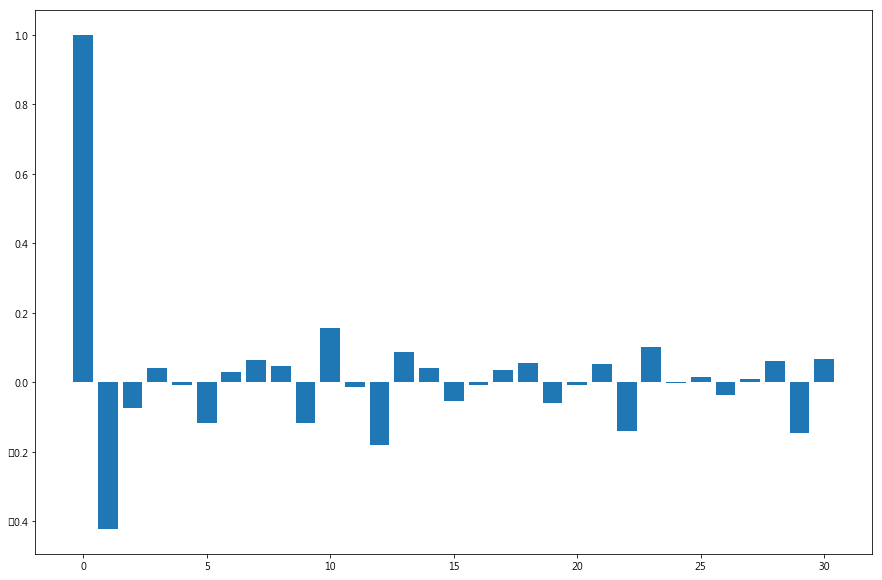

In [99]:
# MA(1)
acf = tsa_tool.acf(train, nlags=30)
x = [i for i in range(0, len(acf))]
plt.bar(x, acf)


<BarContainer object of 31 artists>

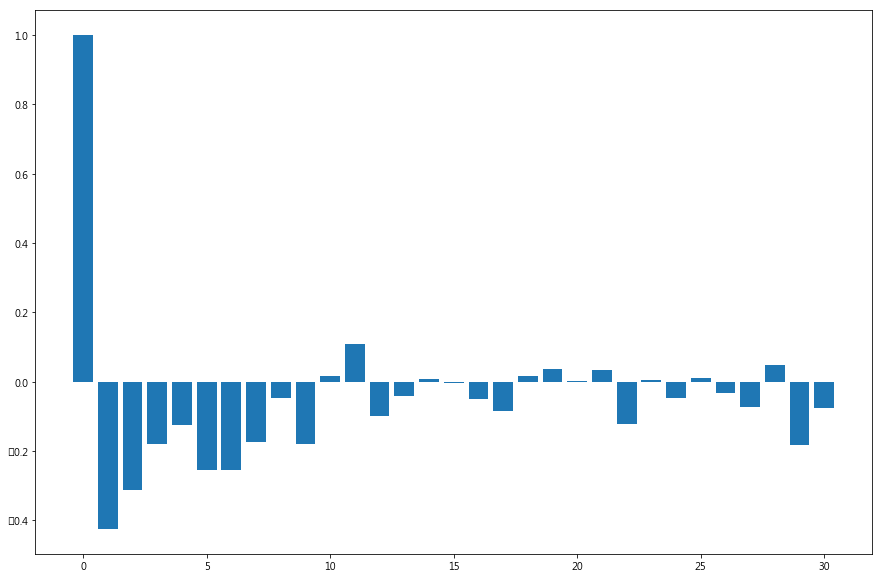

In [100]:
pacf = tsa_tool.pacf(train, nlags=30)
x = [i for i in range(0, len(pacf))]
plt.bar(x, pacf)

In [120]:
# ARIMA D= 2
ARMA01 = arima_model.ARMA(train, (0,1)).fit()
ARMA01.aic

D:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


450.20985104149185

In [128]:
# 11 最好
ARMA11 = arima_model.ARMA(train, (1,1)).fit()
ARMA11.aic
# ARMA11.resid

D:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


448.5555858988343

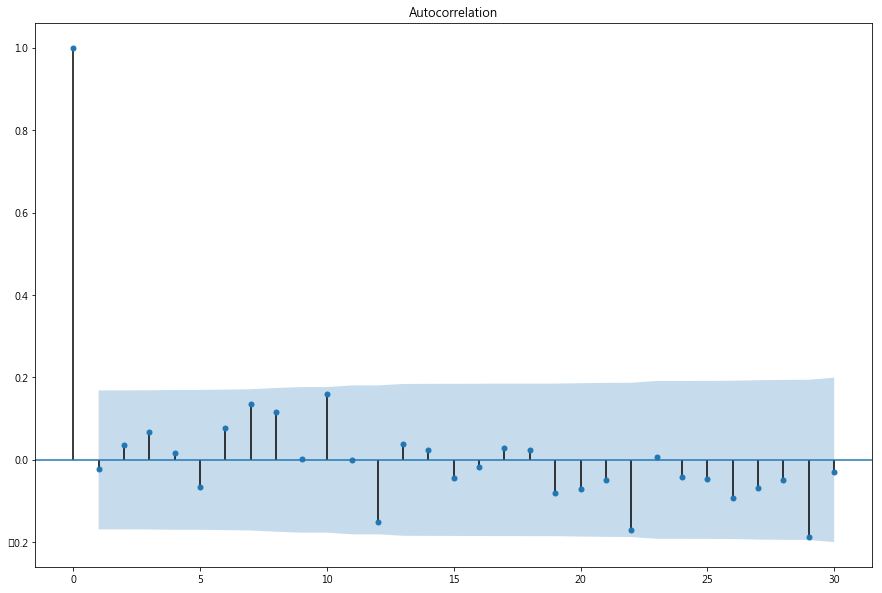

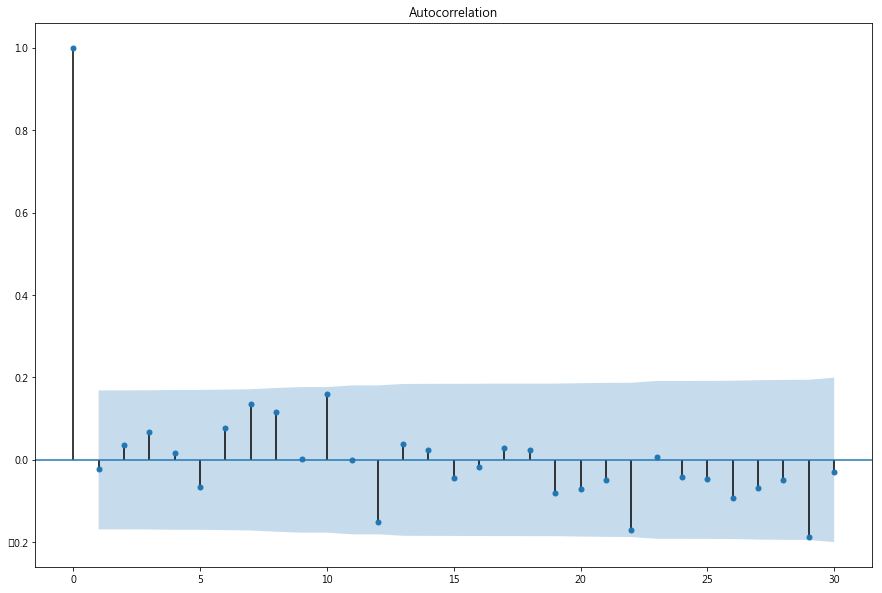

In [129]:
# 確認ARMA(1,1)的殘差是白噪音 => 勉強是ㄅ
import statsmodels.graphics.tsaplots as tsaplots
tsaplots.plot_acf(ARMA11.resid, lags=30)

In [130]:
# 一階自相關檢測，如果~=2 則無自相關 接近0或4則有自相關 =>我也還沒看到這東西的原理
import statsmodels.stats.stattools as stats
stats.durbin_watson(ARMA11.resid.values)

2.0347211210196345

In [159]:
# ARMA predict，我不太理解這套件的start end 到底是發生甚麼事情?
start = np.datetime64('2019-07-29')
end = np.datetime64('2019-08-19')

arma_pre = ARMA11.predict(len(train), len(train) + len(test)-1)
print(arma_pre)

135    0.164865
136    0.036706
137    0.007962
138    0.001515
139    0.000069
140   -0.000255
141   -0.000328
142   -0.000344
143   -0.000348
144   -0.000349
145   -0.000349
146   -0.000349
147   -0.000349
148   -0.000349
149   -0.000349
dtype: float64


D:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


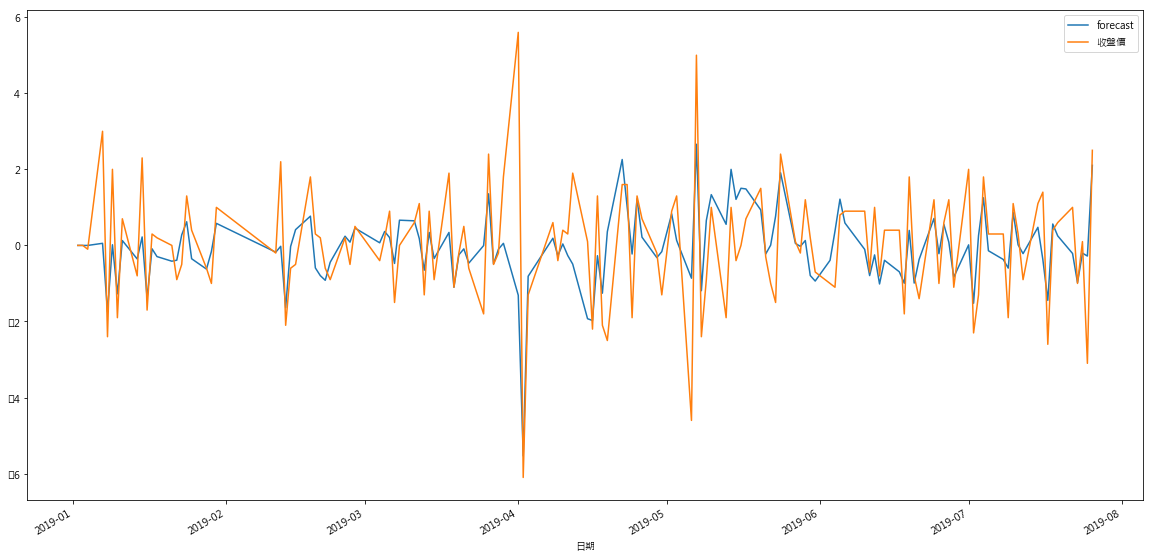

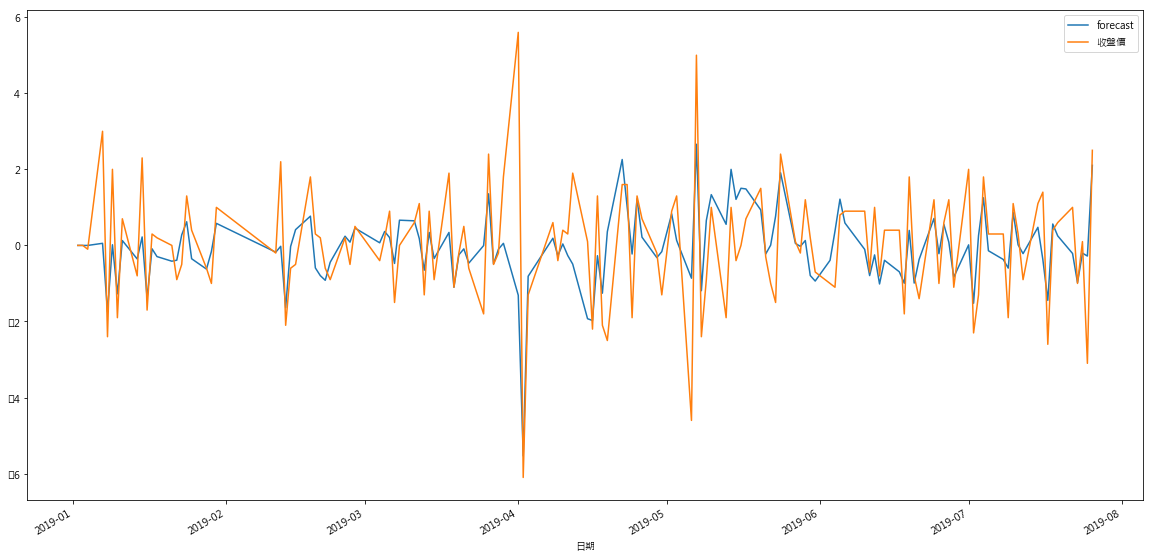

In [164]:
# ARMA(1,1) 練完後再train裡面的效果，看起來就有抓到一點趨勢而已
ARMA11.plot_predict()

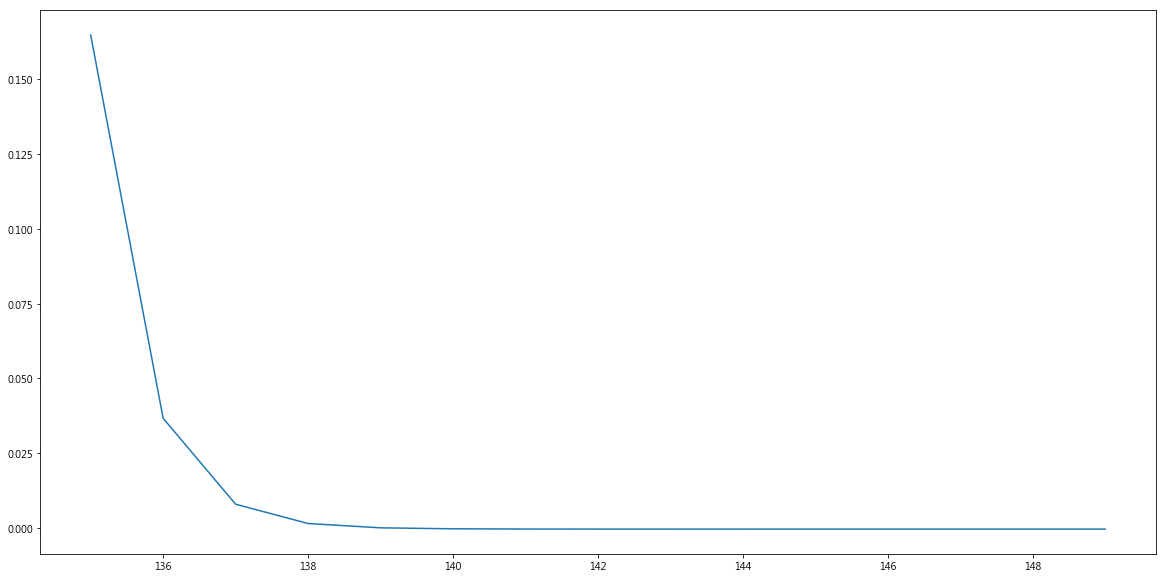

In [165]:
# 由於用預測來推之後的結果所以就收斂囉~~
#但是在預測第一個值的時候還滿準的 real = 2 pre = 1.6
# 所以用ARIMA 來做趨勢應該可行但是準確值就要再加油
arma_pre.plot()

In [166]:
test

日期
2019-07-29    0.2
2019-07-30   -0.6
2019-07-31    1.4
2019-08-01   -1.5
2019-08-02   -1.7
2019-08-05   -0.3
2019-08-06    3.2
2019-08-07   -0.9
2019-08-08    0.6
2019-08-12    0.4
2019-08-13   -1.4
2019-08-14    0.5
2019-08-15   -0.7
2019-08-16    1.4
2019-08-19    0.0
Name: 收盤價, dtype: float64

In [31]:
#ETS

ets = ses.ExponentialSmoothing(endog = train.values, trend="add", seasonal="add", damped=True, seasonal_periods=5).fit()
ets_noseasonal = ses.ExponentialSmoothing(endog = train.values, trend="add", seasonal=None, damped=True, seasonal_periods=5).fit()

In [32]:
ets_arr = ets.forecast(15)
ets_ns_arr = ets_noseasonal.forecast(15)
decompose = seasonal_decompose(train.values, model="additive", freq=5)

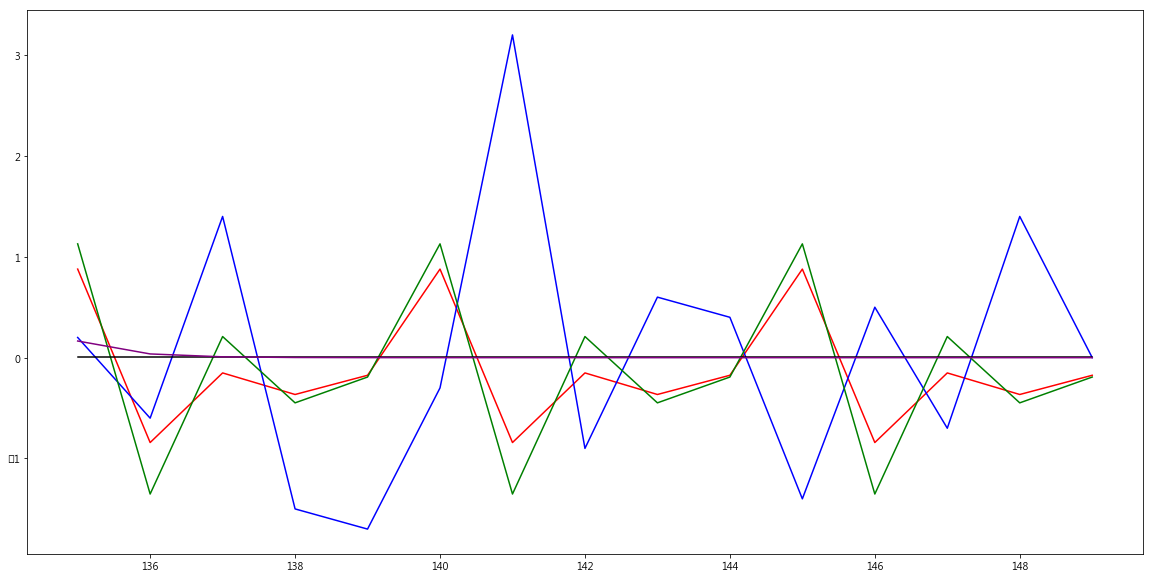

In [154]:
# naive ets + seasonal
# 注意這些都是用二階差分在座的，最後還要回推回原本股價
plt.rcParams["figure.figsize"] = (20,10)
seasonal = decompose.seasonal[0:15]
x = [i for i in range(len(train),len(train)+15)]
# plt.plot(train.values)
plt.plot(x, ets_arr, 'r', x, test, 'b', x, ets_arr+seasonal, 'g', x, ets_ns_arr, 'black', x, arma_pre, 'purple')
# plt.plot(x, ets_arr, 'r', x, test, 'b', x, ets_arr+seasonal, 'g')
